In [15]:
import numpy as np
import matplotlib.pyplot as plt
# galvo fov calculation
Galvo_angle = 6.5
galvo_angle_rad = np.deg2rad(Galvo_angle)
f_sl = 50 # mm
f_tl = 200 # mm
f_obj = 9 # mm

four_f_system_mag = np.arctan(np.tan(galvo_angle_rad) * f_sl / f_tl) / galvo_angle_rad
four_f_system_mag_near = f_sl / f_tl
FOV_galvo_theory = 2*np.tan(galvo_angle_rad * four_f_system_mag) * f_obj * 1000 # um
print(f"theory FOV from galvo: {FOV_galvo_theory:.2f} um")

FOV_galvo_approx = 2*np.tan(galvo_angle_rad * four_f_system_mag_near) * f_obj * 1000 # um
print(f"approx FOV from galvo: {FOV_galvo_approx:.2f} um")
pixel_len = FOV_galvo_theory/(mag * img_dim) 



theory FOV from galvo: 512.71 um
approx FOV from galvo: 510.65 um


## Quick look picture

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

PIL mode: P
PIL mode: L


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/732025502.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


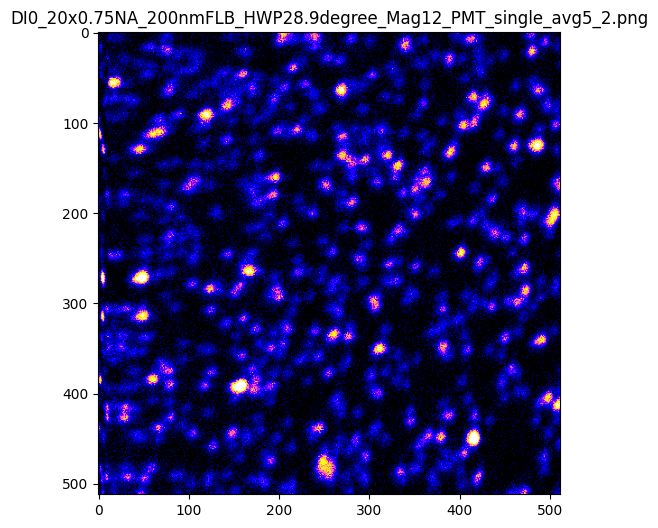

In [17]:
# open PNG image plot with matplotlib
fileDir = './4_data/trainning/'
fileName = 'DI0_20x0.75NA_200nmFLB_HWP28.9degree_Mag12_PMT_single_avg5_2.png'



img = Image.open(fileDir + fileName)
print("PIL mode:", img.mode) # mode 屬性會告訴你色彩模式

img = img.convert('L')  # convert to grayscale
print("PIL mode:", img.mode)
img_array = np.array(img)
fig1, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_array, cmap='gnuplot2')
ax.set_title(fileName)
fig1.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/3907055257.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


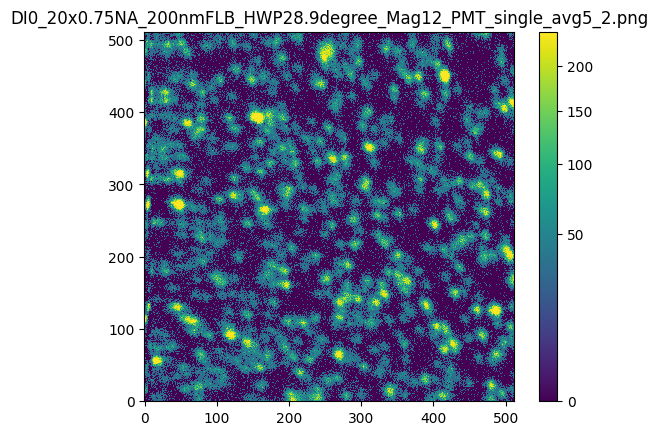

In [18]:
from vidualize import plot_picture

fig, ax = plot_picture(img_array, percent= 99.5)
ax.set_title(fileName)
fig.show()

## Background extract

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/1419233777.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


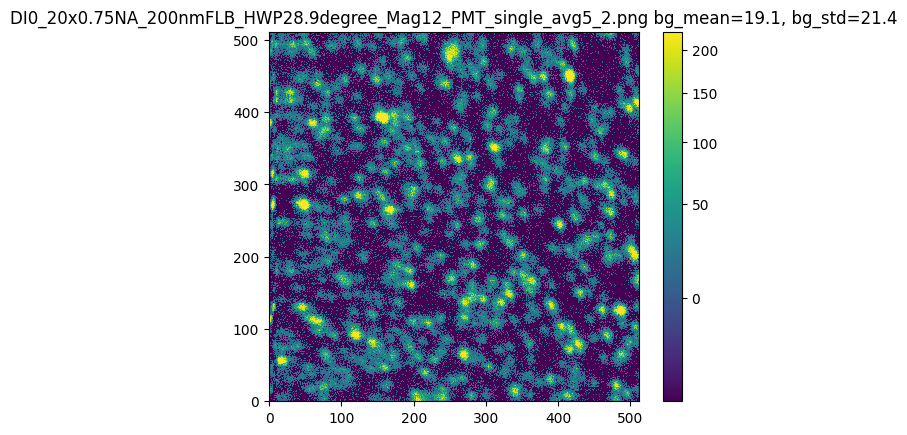

In [19]:
# viw the region that > bg_mean + kappa*std -> source
# let it be a great value to see it
from kapasigmaClip import kappaSigmaClipping

mask, bg_mean, bg_std = kappaSigmaClipping(3, 20, img_array)
image_clean_bg = img_array - bg_mean # remove background mean
fig, ax = plot_picture(image_clean_bg, percent= 99.5)
ax.set_title(fileName + f' bg_mean={bg_mean:.1f}, bg_std={bg_std:.1f}')
fig.show()


## Find source

In [20]:
from findSource import find_source, plot_source

sources = find_source(image_clean_bg, sigma=3, fwhm=8.0, threshold_times=2)
print(f"Found {len(sources)} sources")

Found 260 sources


## Plot source hold radius

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/2723434240.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


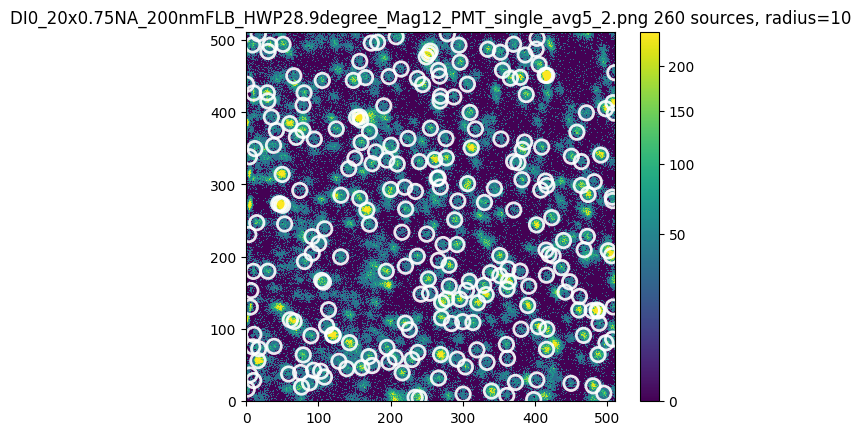

In [21]:
radius = 10
fig, ax = plot_source(img_array, sources, radius=radius, percent=99.5)
ax.set_title(f'{fileName} {len(sources)} sources, radius={radius}') 
fig.show()

## FWHM 2D fitting
Use a fix size square area (ex: 12 * 12 pixels) to fit 2D gaussian, 
the sixe of square nedd to guess based on image.

astropy.modeling models Gaussian2D
since we don't know fwhm, the fitting iteration is high, in this case = 10000

In [22]:
from fwhm2d import FWHM2d


fwhm_x_list, fwhm_y_list, mask = FWHM2d(sources, img_array, sub_size_half=9)
sources['x_fwhm'] = fwhm_x_list
sources['y_fwhm'] = fwhm_y_list
sources = sources[mask]  # only keep the sources with valid FWHM


dict_keys(['nfev', 'fvec', 'fjac', 'ipvt', 'qtf', 'message', 'ierr', 'param_jac', 'param_cov', 'njev', 'cov_x'])
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
1


Text(0.5, 1.0, 'DI0_20x0.75NA_200nmFLB_HWP28.9degree_Mag12_PMT_single_avg5_2.png with FWHM elipse')

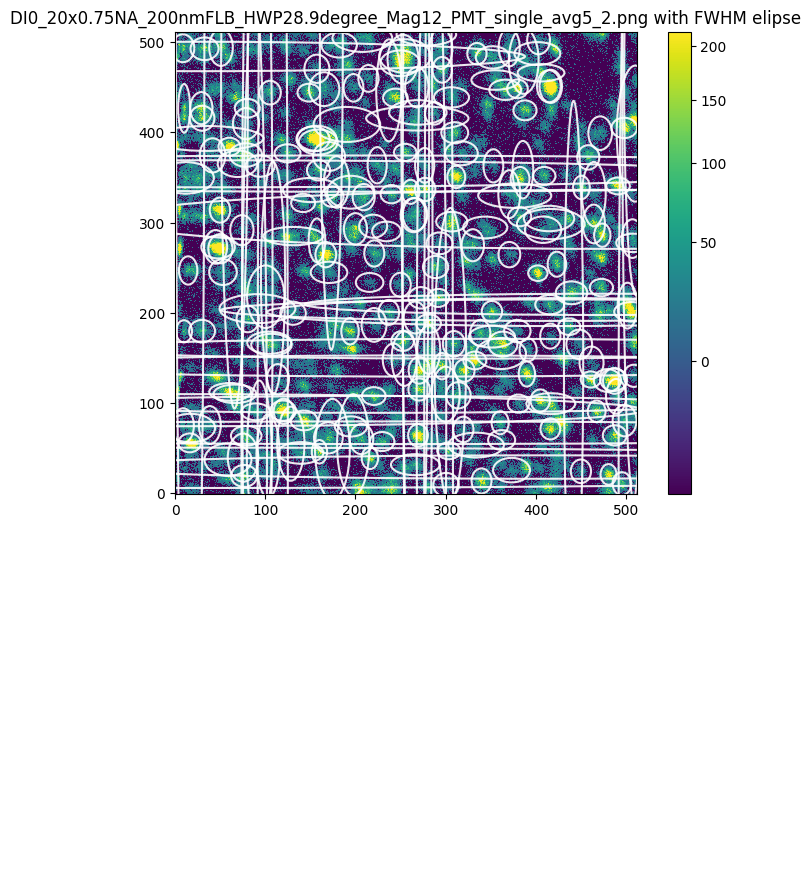

In [23]:
from fwhm2d import plot_source_fwhm_ellips

fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')

## Clean source with strange FWHM

### Plot FWHM distribution

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/675293388.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


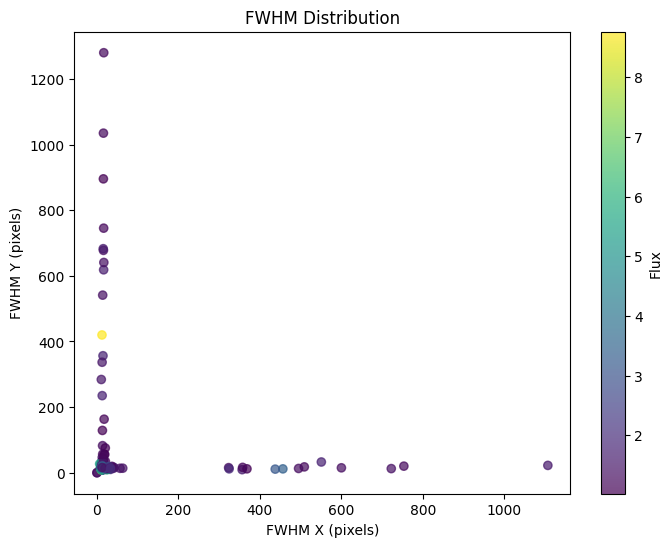

In [24]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm'], sources['y_fwhm'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

### delete FWHM > threshhold sources

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/1948675915.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Cleaned sources: 78


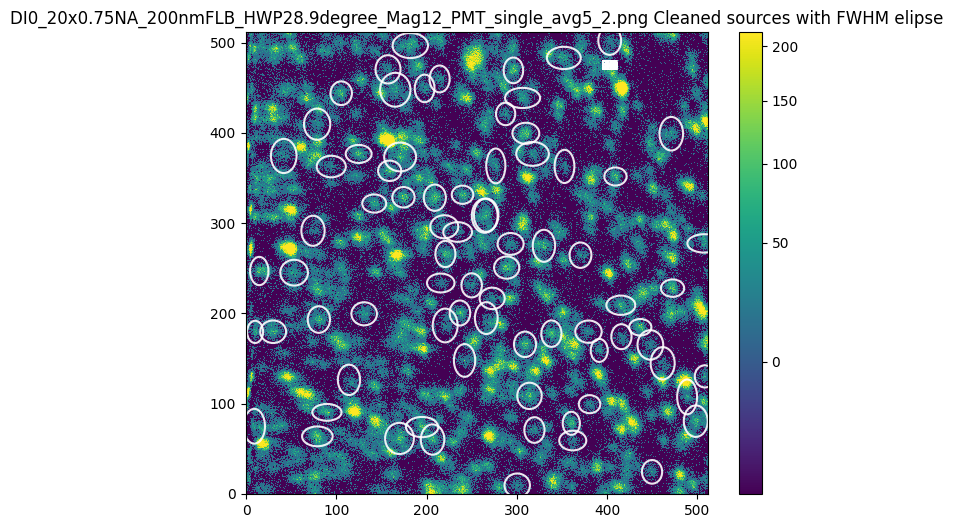

In [25]:
fwhm_threshhold_high = 20
fwhm_threshhold_low = 5
flux_threshhold_high = 3.5
mask = (
    (sources['x_fwhm'] < fwhm_threshhold_high) &
    (sources['y_fwhm'] < fwhm_threshhold_high) &
    (sources['x_fwhm'] > fwhm_threshhold_low) &
    (sources['y_fwhm'] > fwhm_threshhold_low) &
    (sources['flux'] < flux_threshhold_high)
)
source_cleaned = sources[mask]
print(f"Cleaned sources: {len(source_cleaned)}")
fig, ax = plot_source_fwhm_ellips(image_clean_bg, source_cleaned, figsize=(8, 6))
ax.set_title(f'{fileName} Cleaned sources with FWHM elipse')
fig.show()



## FWHMx y 1D fitting
Use FWHM 2D fitting result as initioal fitting parm fit again
not sure is this is necessary, but for plot 1D fitting convenience, just fit again...

### X

In [26]:
from fwhm1d import fit_gaussian_xy_new, plot_fit_gaussian_and_data
rms_x_list = []
num_sources = len(sources)
axis = 'x'
avg_pixel_num = 6
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )
    rms_x_list.append(rms)

sources['rms_fit_x'] = rms_x_list
sources = sources[np.isfinite(sources['rms_fit_x'])].copy()


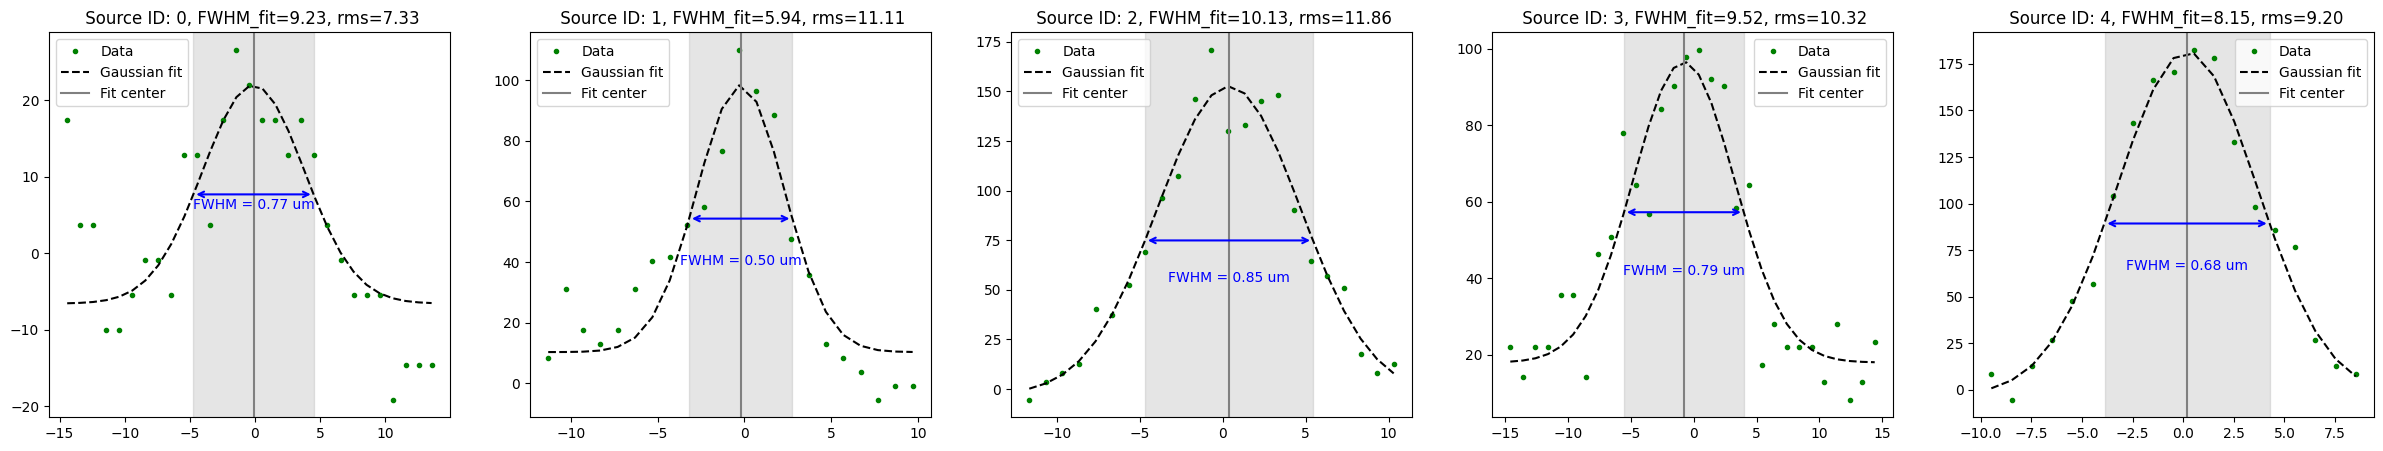

In [28]:
# plot
from fwhm1d import plot_fit_gaussian_and_data
num_sources = len(sources)
max_plot_num = 5
axis = 'x'
num_cols = 5
num_rows = (min(max_plot_num, num_sources) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))
axes = axes.flatten()  # 將 2D 陣列展平為 1D 陣列
for i in range(min(max_plot_num, num_sources)):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )    
    # fig, ax = plot_fit_gaussian_and_data(
    #     sources, sourceID=i, parm=parm, x_rel=main_rel_range,
    #     intensity_profile=intensity_profile, x0=x0, axis=axis, ax=axes[i]
    # )
    fig, ax = plot_fit_gaussian_and_data(parm = parm, x_rel = main_rel_range, 
                                         intensity_profile = intensity_profile, 
                                         pixel_len_um=pixel_len,
                                         ax=axes[i])
     # sigma to FWHM
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")


### Y

In [29]:
from fwhm1d import fit_gaussian_xy_new, plot_fit_gaussian_and_data
rms_y_list = []
num_sources = len(sources)
axis = 'y'
avg_pixel_num = 6
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )
    rms_y_list.append(rms)

sources['rms_fit_y'] = rms_y_list
sources = sources[np.isfinite(sources['rms_fit_y'])].copy()


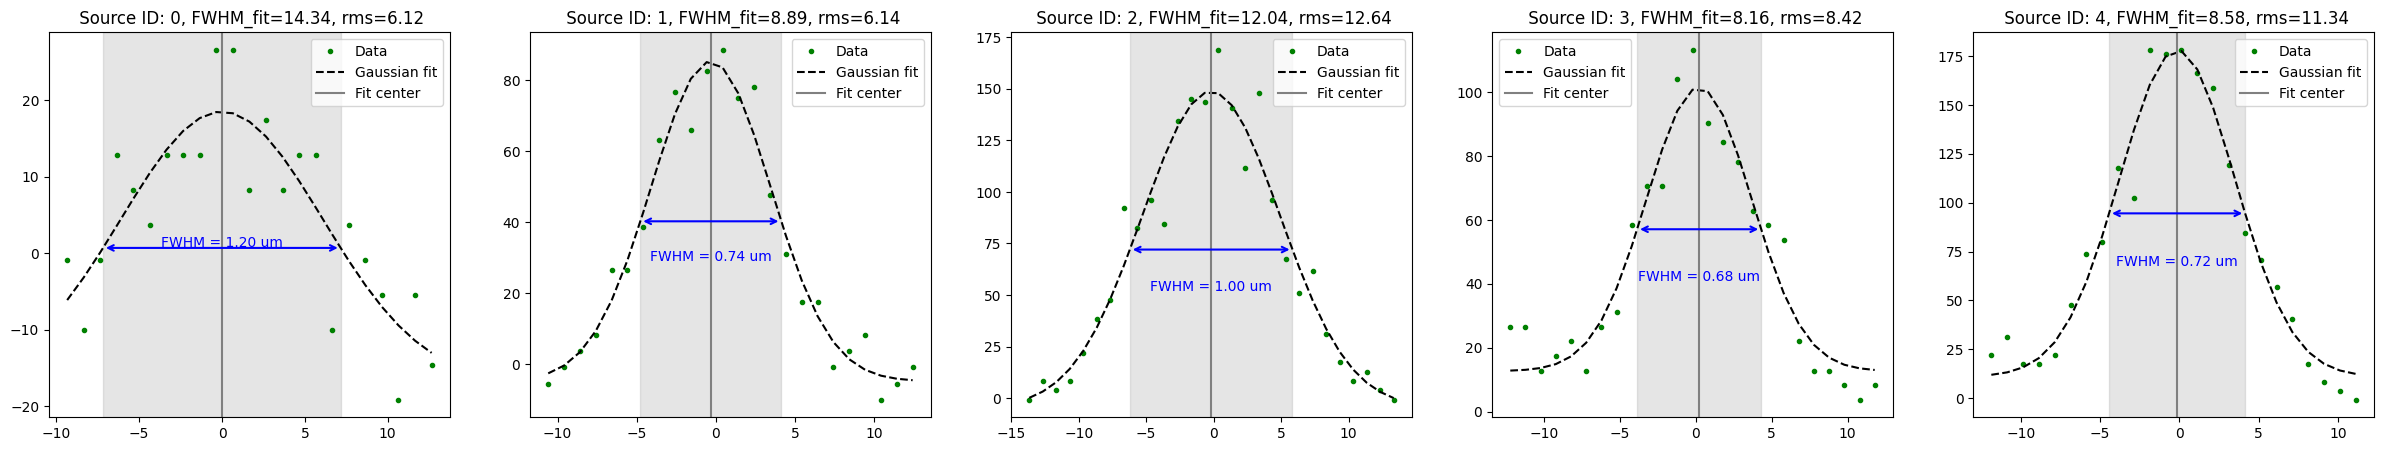

In [31]:
# plot
num_sources = len(sources)
max_plot_num = 5
axis = 'y'
num_cols = 5
num_rows = (min(max_plot_num, num_sources) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))
axes = axes.flatten()  # 將 2D 陣列展平為 1D 陣列
for i in range(min(max_plot_num, num_sources)):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )    
    fig, ax = plot_fit_gaussian_and_data(
        parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, 
        pixel_len_um=pixel_len,
        ax=axes[i]
    )
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/3205519490.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


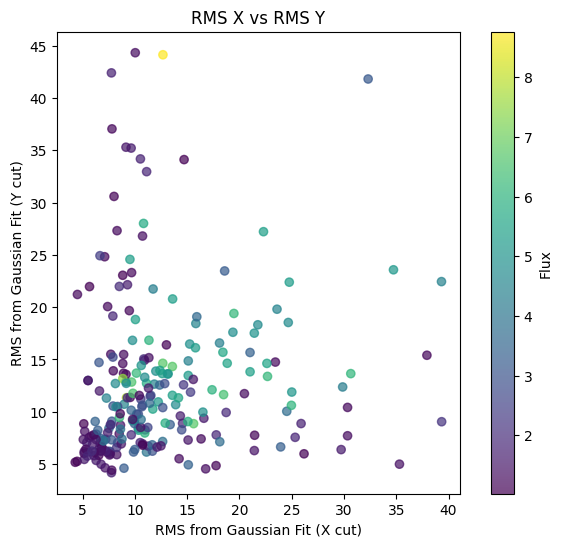

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['rms_fit_x'], sources['rms_fit_y'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('RMS from Gaussian Fit (X cut)')
ax.set_ylabel('RMS from Gaussian Fit (Y cut)')
ax.set_title('RMS X vs RMS Y')
# let x y scale same
ax.set_aspect('equal', 'box')

fig.show()

### Clean again

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/2964608650.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Cleaned sources: 77


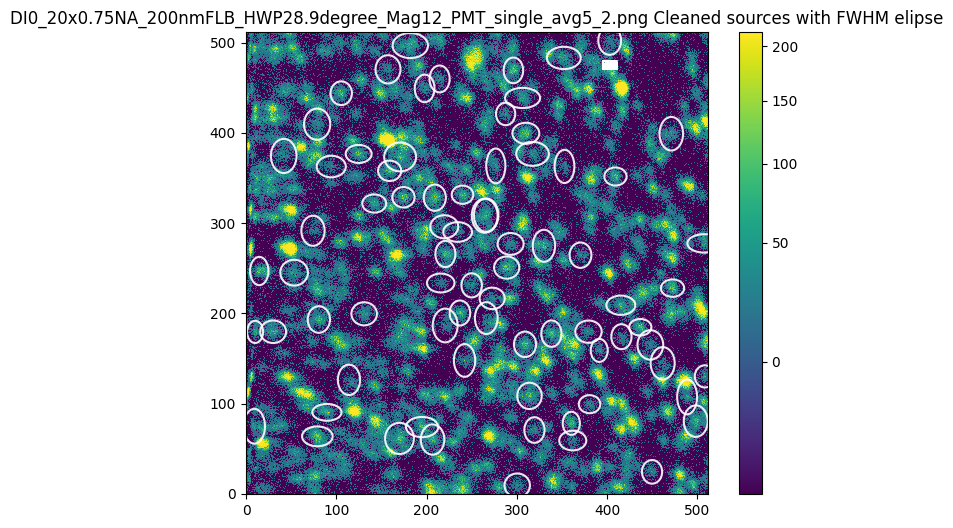

In [33]:
fwhm_threshhold_high = 20
fwhm_threshhold_low = 5
flux_threshhold_high = 3.5
mask = (
    (sources['x_fwhm'] < fwhm_threshhold_high) &
    (sources['y_fwhm'] < fwhm_threshhold_high) &
    (sources['x_fwhm'] > fwhm_threshhold_low) &
    (sources['y_fwhm'] > fwhm_threshhold_low) &
    (sources['flux'] < flux_threshhold_high)
)
sources = sources[mask]
print(f"Cleaned sources: {len(sources)}")
fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
ax.set_title(f'{fileName} Cleaned sources with FWHM elipse')
fig.show()



/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/313886698.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


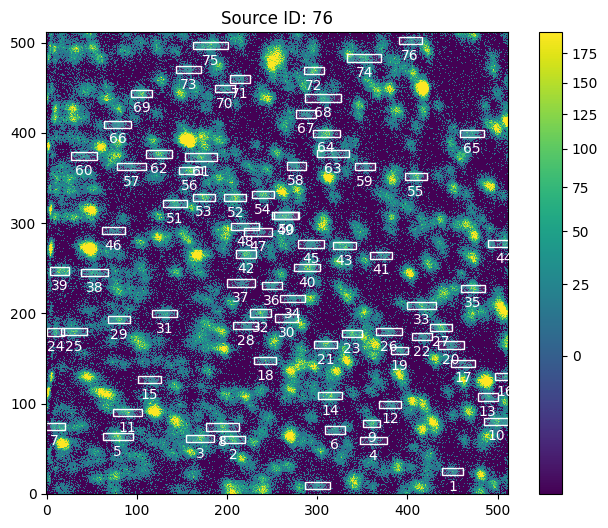

In [34]:
import matplotlib.patches as patches

source_id = 1
fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(sources)):
    source_id = i
    x0, y0, x_half_range, y_half_range = sources[source_id]['xcentroid'], sources[source_id]['ycentroid'], sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.set_title('Source ID: {}'.format(source_id))
    fig1.show()

## FWHM calculation

### FOV by measure

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/871116255.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


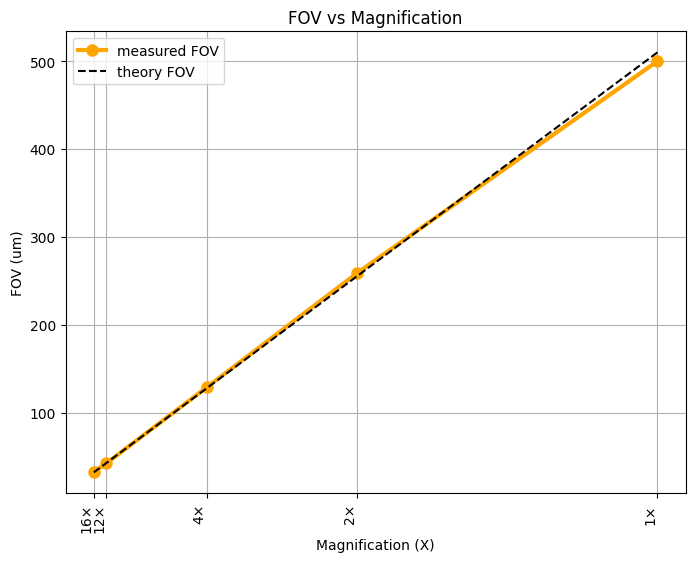

In [35]:
import matplotlib.pyplot as plt
import numpy as np

fov_mag = np.array([1, 2, 4, 12, 16])
fov_pixel_per_mm = np.array([1024, 1980.5, 3984, 12141, 15808])

fov_arr = 512 / fov_pixel_per_mm

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(1/fov_mag, fov_arr * 1000, marker='o', linestyle='-', 
        label='measured FOV', color ='orange', markersize=8, linewidth=3)

fov_theory_arr = 510 / fov_mag
ax.plot(1/fov_mag, fov_theory_arr, marker='', linestyle='--', label='theory FOV', color='black')
# set x label to mag
plt.xticks(1/fov_mag, [str(m) + '×' for m in fov_mag])
plt.setp(plt.gca().get_xticklabels(), rotation=90, ha='right')


ax.set_xlabel('Magnification (X)')
ax.set_ylabel('FOV (um)')
ax.set_title('FOV vs Magnification')
ax.grid(True)
ax.legend()
fig.show()

### FOV by calculation

In [36]:
# lens FOV calculation
FN = 26.5 # field num, mm
Mag = 20 # magnification
FOV_lens = FN / Mag # um

print(f"lens FOV from lens: {FOV_lens:.2f} mm")

lens FOV from lens: 1.32 mm


In [37]:
# galvo fov calculation
Galvo_angle = 6.5
galvo_angle_rad = np.deg2rad(Galvo_angle)
f_sl = 50 # mm
f_tl = 200 # mm
f_obj = 9 # mm

four_f_system_mag = np.arctan(np.tan(galvo_angle_rad) * f_sl / f_tl) / galvo_angle_rad
four_f_system_mag_near = f_sl / f_tl
FOV_galvo_theory = 2*np.tan(galvo_angle_rad * four_f_system_mag) * f_obj * 1000 # um
print(f"theory FOV from galvo: {FOV_galvo_theory:.2f} um")

FOV_galvo_approx = 2*np.tan(galvo_angle_rad * four_f_system_mag_near) * f_obj * 1000 # um
print(f"approx FOV from galvo: {FOV_galvo_approx:.2f} um")


theory FOV from galvo: 512.71 um
approx FOV from galvo: 510.65 um


### NA and 1/e radii calculation

In [38]:
n = 1
f_obj = 9 # mm
D = 6.3 # mm
NA = n * np.sin(np.arctan(D/(2*f_obj)))
print(f"NA: {NA:.4f}")

NA: 0.3304


In [39]:
landa = 920 # nm
omega_xy = 0.320 * landa / (NA * np.sqrt(2))
print(f"1/e radii omega_zy: {omega_xy:.4f} nm")

omega_z = 0.532 * landa / (np.sqrt(2)) * 1/(n-np.sqrt(n**2 - NA**2))
print(f"1/e radii omega_z: {omega_z:.4f} nm")

1/e radii omega_zy: 630.1558 nm
1/e radii omega_z: 6164.5210 nm


### theory fwhm calculation

In [40]:
fwhm_xy = omega_xy * 2 * np.sqrt(np.log(2))
print(f"theory FWHM xy: {fwhm_xy:.4f} nm")
fwhm_z = omega_z * 2 * np.sqrt(np.log(2))
print(f"theory FWHM z: {fwhm_z:.4f} nm")

theory FWHM xy: 1049.2782 nm
theory FWHM z: 10264.6008 nm


In [41]:
# mag = 12, 12141 pixel/mm
mag = 12
img_dim = 512
pixel_len = FOV_galvo_theory/(mag * img_dim) 
print(f"Pixel size: {pixel_len:.2f} um")
fwhm_x_mean = np.average(sources['x_fwhm'])*pixel_len # um
fwhm_y_mean = np.average(sources['y_fwhm'])*pixel_len # um
fwhm_x_std = np.std(sources['x_fwhm'])*pixel_len # um
fwhm_y_std = np.std(sources['y_fwhm'])*pixel_len # um
print(f"Average FWHM X: {fwhm_x_mean:.4f} um ± {fwhm_x_std:.4f} um")
print(f"Average FWHM Y: {fwhm_y_mean:.4f} um ± {fwhm_y_std:.4f} um")



Pixel size: 0.08 um
Average FWHM X: 1.1196 um ± 0.1979 um
Average FWHM Y: 1.1682 um ± 0.2403 um


## Violin plot of FWHM x y 1D fit

(0.596078431372549, 0.4486274509803921, 0.2650980392156862)
(0.44392156862745114, 0.5309803921568628, 0.5599999999999999)


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/2915603575.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM X', 'FWHM Y'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/2915603575.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


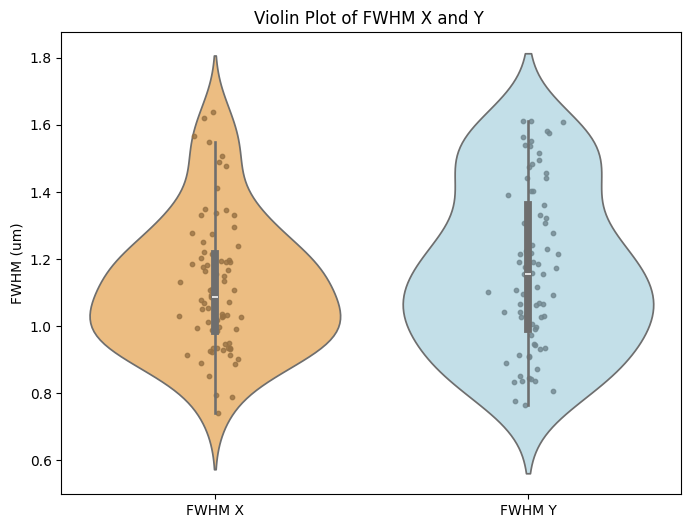

In [42]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')

pixel_len = FOV_galvo_theory/(Mag*img_dim) # um

for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    print(dark_color)
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)

ax.set_title('Violin Plot of FWHM X and Y ')
fig.show()

## Final Source! 

In [43]:
# select mean(fwhm) +- factor*std => let meam +- > factor*std be outlier
factor = 2
fwhm_x_mean = np.mean(sources['x_fwhm'])
fwhm_x_std = np.std(sources['x_fwhm'])
fwhm_y_mean = np.mean(sources['y_fwhm'])
fwhm_y_std = np.std(sources['y_fwhm'])

mask_x = (sources['x_fwhm'] > (fwhm_x_mean - factor*fwhm_x_std)) & (sources['x_fwhm'] < (fwhm_x_mean + factor*fwhm_x_std))
mask_y = (sources['y_fwhm'] > (fwhm_y_mean - factor*fwhm_y_std)) & (sources['y_fwhm'] < (fwhm_y_mean + factor*fwhm_y_std))
mask = mask_x & mask_y
sources = sources[mask]

final_sources = sources


### elipse image plot

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/3271009537.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


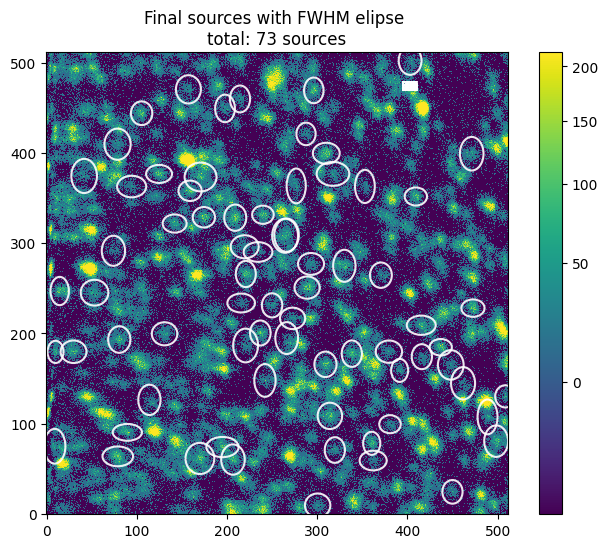

In [44]:
fig, ax = plot_source_fwhm_ellips(image_clean_bg, final_sources, figsize=(8, 6))
ax.set_title(f'Final sources with FWHM elipse \ntotal: {len(final_sources)} sources')
fig.show()

### sample rectangle

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/2641538511.py:2: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/2641538511.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


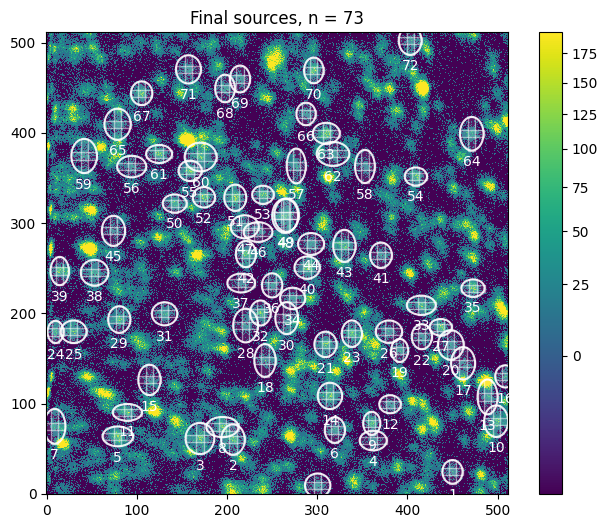

In [45]:
import matplotlib.patches as patches
from photutils import EllipticalAperture
fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(final_sources)):
    source_id = i
    # x fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], final_sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 0.5), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # y fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], avg_pixel_num//2+1, final_sources[source_id]['y_fwhm']
    rect2 = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 0.5), # white, alpha
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # draw x y as a b ellips
    position = (x0, y0)
    a = final_sources[i]['x_fwhm']  # x軸半徑
    b = final_sources[i]['y_fwhm']  # y軸半徑
    theta = 0  # 橢圓角度（如有可用 source['theta']）
    aperture = EllipticalAperture(position, a=a, b=b, theta=theta)

    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.add_patch(rect2)
    aperture.plot(color='white', lw=1.5, alpha=0.9, ax=ax)
    ax.set_title(f"Final sources, n = {len(final_sources)}")
    fig1.show()



### single sample x

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/1995017542.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


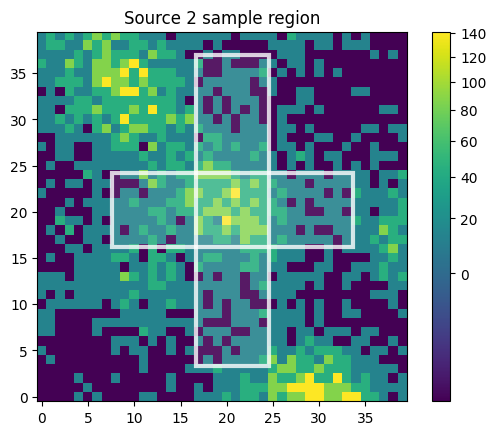

In [46]:
source_id = 2
edge_half_len = 20
    # y fwhm rectangle
x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], avg_pixel_num//2+1, final_sources[source_id]['y_fwhm']
# select an area near source to plot
x_min = int(max(0, x0 - edge_half_len))
x_max = int(min(image_clean_bg.shape[1], x0 + edge_half_len))
y_min = int(max(0, y0 - edge_half_len))
y_max = int(min(image_clean_bg.shape[0], y0 + edge_half_len))

rect2 = patches.Rectangle(
    (x0 - x_half_range - x_min, y0 - y_half_range - y_min),  # 左
    2*x_half_range,  # 寬
    2*y_half_range,  # 高
    linewidth=3,
    edgecolor=(1, 1, 1, 0.8), # white, alpha
    facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
)

x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], final_sources[source_id]['x_fwhm'], avg_pixel_num//2+1
rect = patches.Rectangle(
    (x0 - x_half_range - x_min, y0 - y_half_range - y_min),  # 左下角
    2*x_half_range,  # 寬
    2*y_half_range,  # 高
    linewidth=3,
    edgecolor=(1, 1, 1, 0.8), # white, alpha = 1
    facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
)


fig, ax = plot_picture(image_clean_bg[y_min:y_max, x_min:x_max], percent=98.5)
ax.add_patch(rect)
ax.add_patch(rect2)
ax.set_title(f'Source {source_id} sample region')
fig.show()


In [47]:
fwhm_fit
pixel_len * fwhm_fit


0.4295364048603856

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/496827750.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


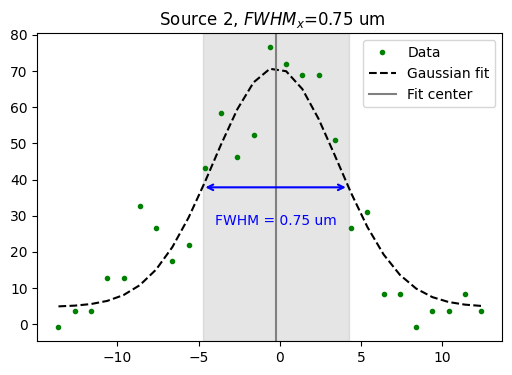

In [48]:
# plot source 1
# reload fit_gaussian_xy_new
from importlib import reload
import fwhm1d
reload(fwhm1d)
from fwhm1d import fit_gaussian_xy_new, plot_fit_gaussian_and_data
sourceID = 2
axis = 'x'
avg_pixel_num = 6
mag = 12
img_dim = 512
pixel_len = FOV_galvo_theory/(mag * img_dim) 

parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=sourceID, axis=axis, avg_pixel_num=avg_pixel_num
    )
fig, ax = plot_fit_gaussian_and_data(
        parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, pixel_len_um=pixel_len
    )
amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
ax.set_title(f" Source {sourceID}, $FWHM_{axis}$={fwhm_fit * pixel_len:.2f} um")
fig.show()



### single sample Y

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_3302/3985452698.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


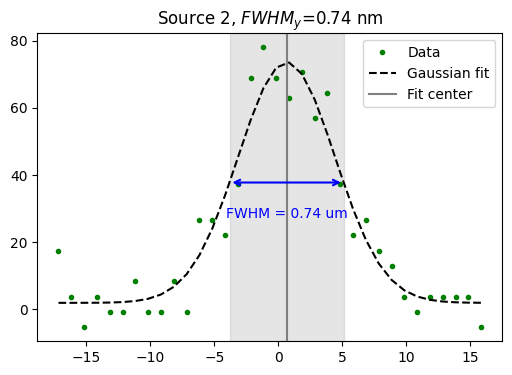

In [49]:
# plot source 1
sourceID = 2
axis = 'y'
avg_pixel_num = 6

parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=sourceID, axis=axis, avg_pixel_num=avg_pixel_num
    )
fig, ax = plot_fit_gaussian_and_data(
        parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile,
        pixel_len_um=pixel_len
    )
amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
ax.set_title(f"Source {sourceID}, $FWHM_{axis}$={fwhm_fit*pixel_len:.2f} nm")
fig.show()



TypeError: plot_fit_gaussian_and_data() missing 1 required positional argument: 'pixel_len_um'

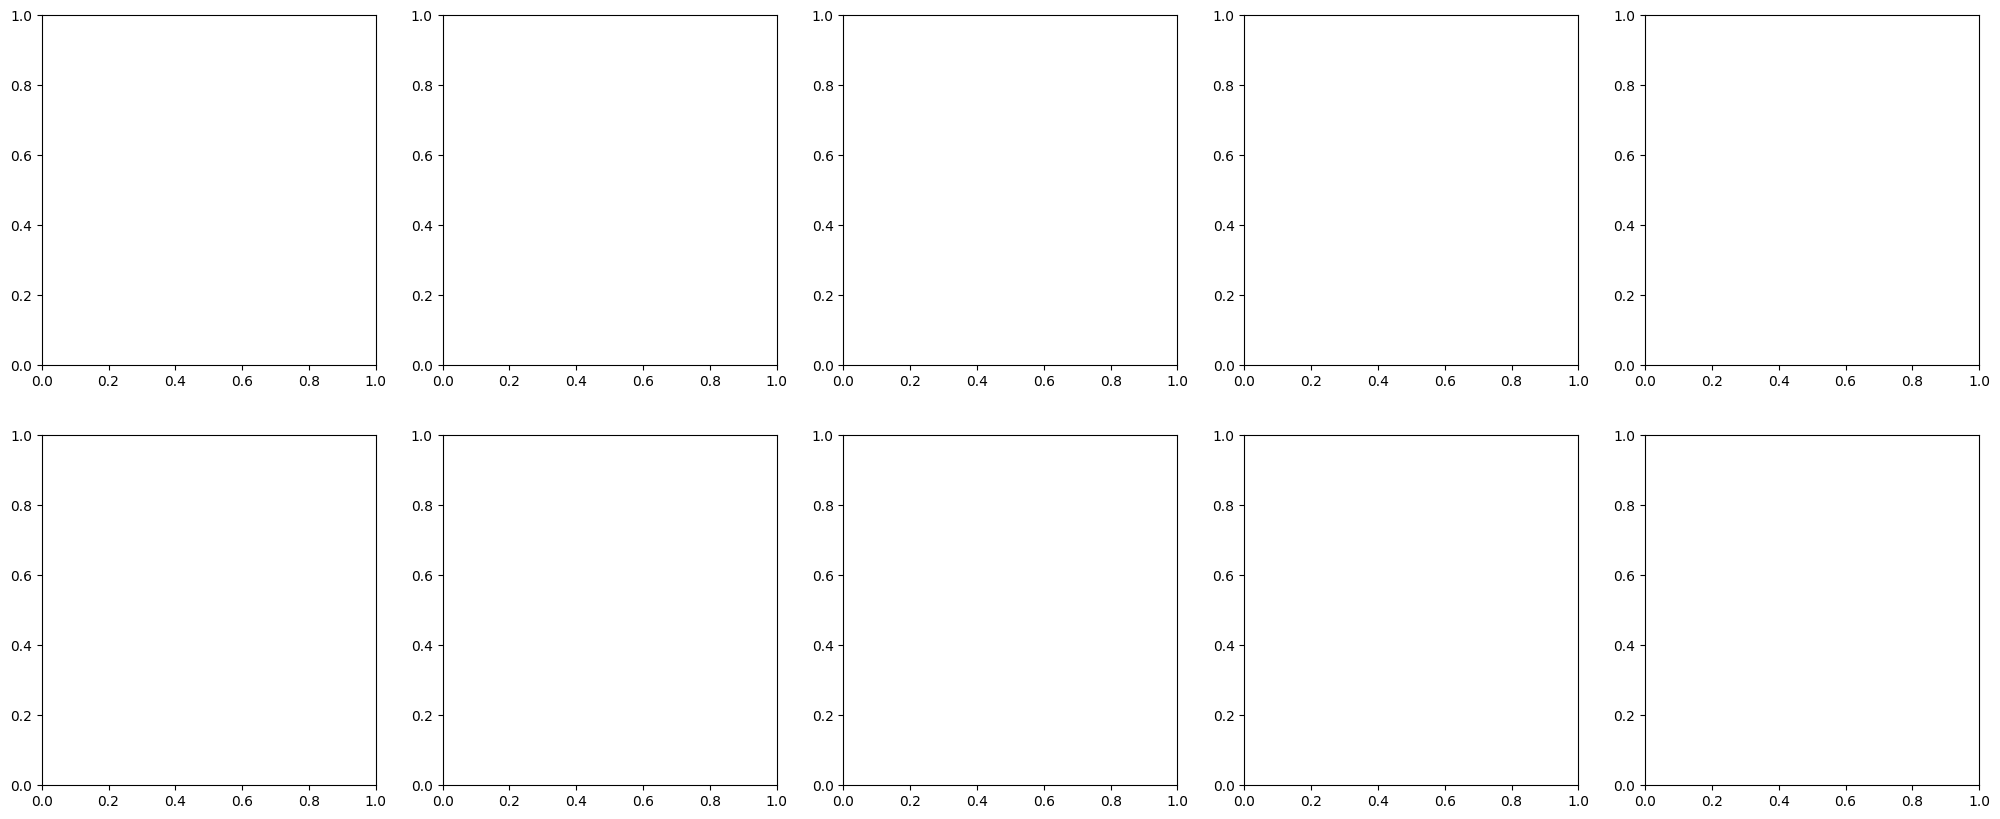

In [50]:
# plot
num_sources = len(final_sources)
max_plot_num = 10
axis = 'x'
num_cols = 5
num_rows = (min(max_plot_num, num_sources) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
axes = axes.flatten()  # 將 2D 陣列展平為 1D 陣列
for i in range(min(max_plot_num, num_sources)):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, final_sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )    
    fig, ax = plot_fit_gaussian_and_data(
        parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, ax=axes[i]
    )
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")

In [ ]:
max(sources['x_fwhm'])

16.92389260807254

### Violin plot

Cleaned FWHM X: 1.08 +- 0.14 um
Cleaned FWHM Y: 1.18 +- 0.24 um


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_65091/3790389902.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM X', 'FWHM Y'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_65091/3790389902.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


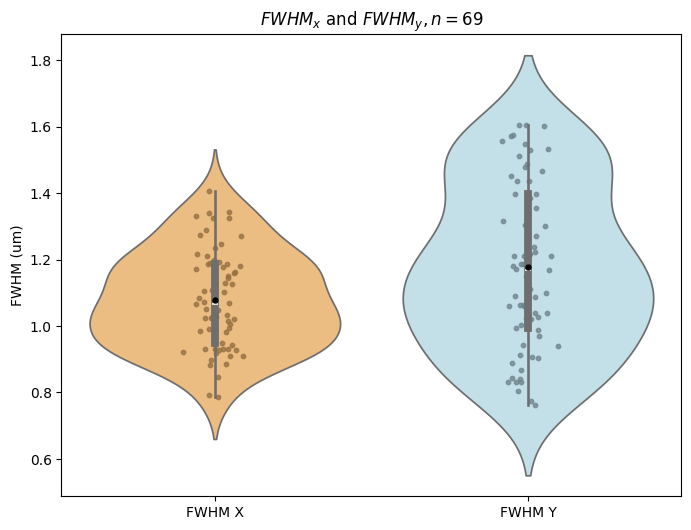

In [ ]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')
# calculate mean and std
mean_y_fwhm_pixel = np.mean(sources['y_fwhm']*pixel_len)
mean_x_fwhm_pixel = np.mean(sources['x_fwhm']*pixel_len)
std_y_fwhm_pixel = np.std(sources['y_fwhm']*pixel_len)
std_x_fwhm_pixel = np.std(sources['x_fwhm']*pixel_len)
print(f"Cleaned FWHM X: {mean_x_fwhm_pixel:.2f} +- {std_x_fwhm_pixel:.2f} um")
print(f"Cleaned FWHM Y: {mean_y_fwhm_pixel:.2f} +- {std_y_fwhm_pixel:.2f} um")
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)
for i in range(len(data)):
    mean_val = np.mean(data[i])
    ax.scatter(i, mean_val, color='black', s=50, marker='.', zorder=10, label='Mean' if i == 0 else "")

ax.set_title(f'$FWHM_x$ and $FWHM_y, n = {len(sources)}$')
fig.show()

In [ ]:
FOV = 510.6 # um <- theory FOV
Mag = 12
img_dim = 512
pixel_len = FOV/(Mag*img_dim) # um
print(f"Pixel size: {pixel_len:.2f} um") 
fwhm_x = np.average(sources['x_fwhm'])*pixel_len # um
fwhm_y = np.average(sources['y_fwhm'])*pixel_len #
print(f"Average FWHM X: {fwhm_x:.4f} um, {np.average(sources['x_fwhm'])} pixels")
print(f"Average FWHM Y: {fwhm_y:.4f} um, {np.average(sources['y_fwhm'])} pixels")

Pixel size: 0.08 um
Average FWHM X: 1.0770 um, 12.959569338216943 pixels
Average FWHM Y: 1.1774 um, 14.166999048246177 pixels


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_65091/3736678162.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


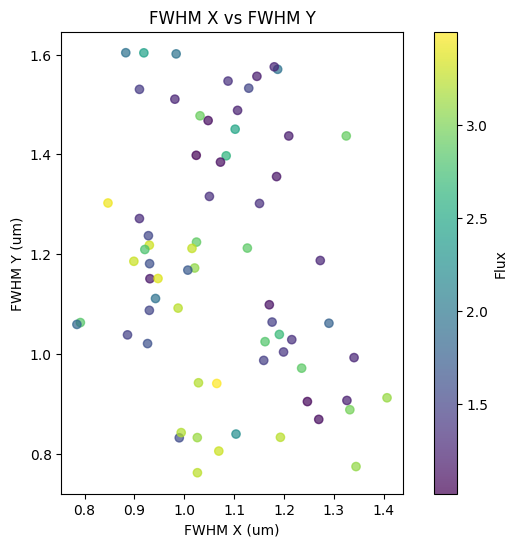

In [ ]:
# plot fwhm x y scatter
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len, c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (um)')
ax.set_ylabel('FWHM Y (um)')
ax.set_title('FWHM X vs FWHM Y')
# let x y scale same
ax.set_aspect('equal', 'box')
fig.show()

In [55]:
a = (10.26-10.08)/10.26 * 100
print(a)

1.7543859649122777
